In [3]:
import pandas as pd
import datetime
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from pylab import rcParams
import warnings
from pandas.core.nanops import nanmean as pd_nanmean

In [4]:
df = pd.read_csv('train.csv')
df.sort_index(inplace=True)

In [5]:
df['error']  = np.linalg.norm(df[['x', 'y', 'z']].values - df[['x_sim', 'y_sim', 'z_sim']].values, axis=1)

<AxesSubplot:>

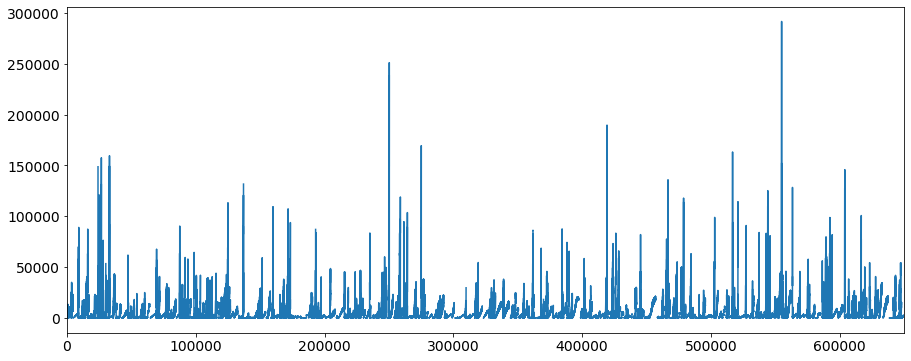

In [6]:
df.error.plot( figsize=(15,6), fontsize=14)

In [7]:
train = df.loc[df['type'] == 'train']
train[(train.epoch >= '2014-01-24') & (train.epoch < '2014-01-25') & (train.sat_id == 3)]

,id,epoch,sat_id,x,y,z,x_sim,y_sim,z_sim,type,error
3746,6883,2014-01-24T00:19:07.840,3,-16973.831386,-45622.343668,-1910.260076,-27447.255676,-21178.081235,-1664.376953,train,26594.643084
3747,6884,2014-01-24T02:25:36.954,3,-27828.577990,-20041.623034,-1729.678989,-22452.509088,12966.473335,-670.662772,train,33459.797640


In [395]:
w = 24

In [282]:
train1 = train.iloc[:-4943]

In [9]:
val   = train.iloc[-w_hours:]
train = train.iloc[:-w_hours]
test = df.loc[df['type'] == 'test']

NameError: name 'w_hours' is not defined

In [112]:
sat_train = []
sat_val = []
w_hours = []
for i in range(600):
    sat_train.append(train[train.sat_id == i])
    #w_hours.append(sat_train[i][(sat_train[i].epoch >= '2014-01-10') & (sat_train[i].epoch < '2014-01-11')].shape[0])
    
    sat_val.append(sat_train[i].iloc[-24:])
    sat_train[i] = sat_train[i].iloc[:-24]

### baseline

In [407]:
sat_preds1 = []
for i in range(600):
    sat_preds1.append([sat_train[i].error.mean()] * w_hours[i])

sat_preds1 = [elem for sublist in sat_preds1 for elem in sublist]

### rmse

In [408]:
from sklearn.metrics import mean_squared_error
from math import sqrt
    
def rmse(y_actual, y_predicted):
    rmse = sqrt(mean_squared_error(y_actual, y_predicted))
    return rmse

In [116]:
trues1 = [list(elem.error) for elem in sat_val]
trues1 = [elem for sublist in trues1 for elem in sublist]

In [410]:
rmse(trues1, sat_preds1)

9389.974265369943

### mape

In [116]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [12]:
def smape(y_true, y_pred): 
    return np.mean(2 * np.abs(y_true - y_pred) / (y_true + y_pred)) * 100

In [411]:
print('MAPE - ', mean_absolute_percentage_error(np.array(trues1), np.array(sat_preds1)))

MAPE -  59.08009391805366


In [412]:
smape(np.array(trues1), np.array(sat_preds1))

66.94442711545703

In [413]:
sat_preds2 = []
for i in range(600):
    sat_preds2.append(sat_train[i].iloc[-w_hours[i]:].error.values)

In [414]:
sat_preds2 = [elem for sublist in sat_preds2 for elem in sublist]

In [415]:
print('RMSE - ', rmse(trues1, sat_preds2))
print('MAPE - ', mean_absolute_percentage_error(np.array(trues1), np.array(sat_preds2)))

RMSE -  9280.086353412527
MAPE -  52.527411874974575


In [416]:
smape(np.array(trues1), np.array(sat_preds2))

39.040084767382375

In [417]:
scores = []
for n in range(1, 8):
    sat_preds3 = []
    pr = []
    tr_sample = []
    for i in range(600):
        tr_sample.append(sat_train[i].iloc[-n*w_hours[i]:])
        pr.append(np.array(tr_sample[i].error).reshape(n,-1))

        sat_preds3.append(pr[i].mean(axis = 0))
    sat_preds3 = [elem for sublist in sat_preds3 for elem in sublist]
    scores.append(smape(np.array(trues1), np.array(sat_preds3)))

In [418]:
scores

[39.040084767382375,
 35.78837132286276,
 35.510720948260555,
 35.93021967059896,
 36.44163402340683,
 37.441504497983026,
 38.17272421633226]

In [435]:
W = np.array([0.01 , 0.01 , 0.03 , 0.05  , 0.25 , 0.25 ,0.4])
n = 7
sat_preds4 = []
pr = []
tr_sample = []
for i in range(600):
    tr_sample.append(sat_train[i].iloc[-n*w_hours[i]:])
    pr.append(np.array(tr_sample[i].error).reshape(n,-1))
    pr[i] = np.array([pr[i][x]*W[x] for x in range(len(W))])
    sat_preds4.append(pr[i].sum(axis = 0))

In [436]:
sat_preds4 = [elem for sublist in sat_preds4 for elem in sublist]

In [437]:
smape(np.array(trues1), np.array(sat_preds4))

35.441155351065554

### Экспоненциальное сглаживание

In [1]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result[-1]

In [26]:
sat_train[1].error

958        32.231758
959        25.082475
960        19.635281
961        20.341250
962        23.983623
            ...     
2466     7231.818353
2467     8371.954476
2468     9576.287510
2469    10671.951327
2470    11037.008817
Name: error, Length: 1513, dtype: float64

In [28]:
exp_res = []
alpha = 0.7
for i in range(600):
    exp_res.append(exponential_smoothing(list(sat_train[i].error), alpha))

In [31]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [67]:
test = df.loc[df['type'] == 'test']

In [114]:
res = []
for i in range(600):
    fit1 = ExponentialSmoothing(np.asarray(sat_train[i].error) ,seasonal_periods=24 ,seasonal='add',).fit()
    forecast = pd.Series(fit1.forecast(24))
    #forecast.index = sat_val[i].index
    res.extend(forecast)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retval

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retval

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retval

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retval

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retval

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retval

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retval

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retval

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retval

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retval

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retval

In [117]:
smape(np.array(trues1), np.array(res))

16.217722280772502

In [97]:
exp_res = pd.DataFrame()
exp_res['error'] = res
exp_res = exp_res.set_index(test['id'])

In [98]:
exp_res

,error
id,
718,11382.510348
719,11383.668778
720,11383.481011
721,11382.230596
722,11380.131847
...,...
1234089,2529.879925
1234090,2532.513473
1234091,2533.164570


In [99]:
exp_res.to_csv('exp_res2.csv')